In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools
import scipy.signal
from tqdm import tqdm
import inspect
import pickle
import sys
import json
import os
sys.path.append('../data_processing/')
sys.path.append('../validation/')
from feature import Feature
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_mutual_info_score, mutual_info_score
from sklearn.preprocessing import StandardScaler
%matplotlib notebook

In [3]:
filepath = '../../data/train_short.h5'
df = pd.read_hdf(filepath, key='table')
df.head()

,s,ttf
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


In [ ]:
windows = [i for i in range(3, 1001, 10)]
mutual_info_results = []
for window in tqdm(windows):
    filtered_signal = Feature(df['s'], '../../data/').r_savgol_filter(window_length=window, verbose=False).data.values.squeeze()
    ttf_signal = df.drop(['s'], axis=1).values.squeeze()
    mutual_info_results.append(normalized_mutual_info_score(ttf_signal, filtered_signal))
    
plt.figure(figsize=(10, 5))
plt.plot(windows, mutual_info_results)

In [ ]:
windows = [i for i in range(3, 1001, 10)]
mutual_info_results = []
for window in tqdm(windows):
    filtered_signal = Feature(df['s'], '../../data/')\
    .r_savgol_filter(window_length=window, verbose=False)\
    .w_std(window_size=1000, window_stride=500, verbose=False)\
    .data.values.squeeze()
    ttf_signal = Feature(df['s'], '../../data/')\
    .w_last_elem(window_size=1000, window_stride=500, verbose=False)\
    .data.values.squeeze()
    mutual_info_results.append(normalized_mutual_info_score(ttf_signal, filtered_signal))
    
plt.figure(figsize=(10, 5))
plt.plot(windows, mutual_info_results)

100%|██████████| 100/100 [00:26<00:00,  2.21it/s]


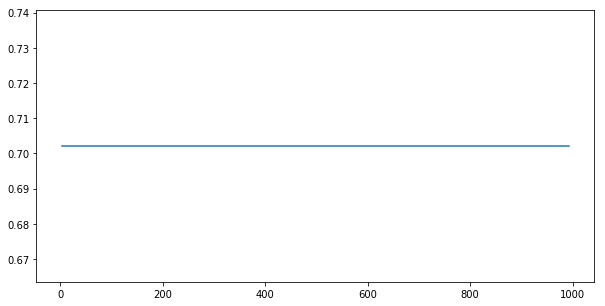

In [4]:
windows = [i for i in range(3, 1001, 10)]
mutual_info_results = []
scaler = StandardScaler()

for window in tqdm(windows):
    filtered_signal = Feature(df['s'], '../../data/')\
    .r_savgol_filter(window_length=window, verbose=False)\
    .w_psd(window_size=10000, window_stride=5000, verbose=False)\
    .data.values
    ttf_signal = Feature(df['s'], '../../data/')\
    .w_last_elem(window_size=10000, window_stride=5000, verbose=False)\
    .data.values
    
    temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
    ttf_signal_scaled = temp_[:, 0]
    filtered_signal_scaled = temp_[:, 1]
    
    score = normalized_mutual_info_score(ttf_signal_scaled, filtered_signal_scaled, average_method="arithmetic")
    mutual_info_results.append(score)
    
plt.figure(figsize=(10, 5))
plt.plot(windows, mutual_info_results)

100%|██████████| 100/100 [00:28<00:00,  2.16it/s]


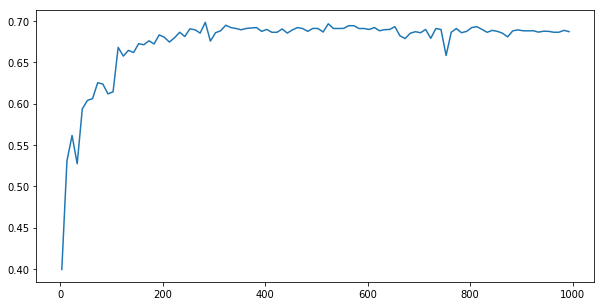

In [5]:
windows = [i for i in range(3, 1001, 10)]
mutual_info_results = []
scaler = StandardScaler()

for window in tqdm(windows):
    filtered_signal = Feature(df['s'], '../../data/')\
    .r_savgol_filter(window_length=window, verbose=False)\
    .w_quantile(window_size=10000, window_stride=5000, q=0.05, verbose=False)\
    .data.values
    ttf_signal = Feature(df['s'], '../../data/')\
    .w_last_elem(window_size=10000, window_stride=5000, verbose=False)\
    .data.values
    
    temp_ = scaler.fit_transform(np.hstack((ttf_signal, filtered_signal)))
    ttf_signal_scaled = temp_[:, 0]
    filtered_signal_scaled = temp_[:, 1]
    
    score = normalized_mutual_info_score(ttf_signal_scaled, filtered_signal_scaled, average_method="arithmetic")
    mutual_info_results.append(score)
    
plt.figure(figsize=(10, 5))
plt.plot(windows, mutual_info_results)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(Feature(df['s'], '../../data/')\
    .r_savgol_filter(window_length=3, verbose=False)\
    .w_psd(window_size=10000, window_stride=5000, verbose=False)\
    .data.values.squeeze(), 'k')
plt.plot(Feature(df['s'], '../../data/')\
    .r_savgol_filter(window_length=5, verbose=False)\
    .w_psd(window_size=10000, window_stride=5000, verbose=False)\
    .data.values.squeeze(), 'r')
plt.plot(Feature(df['s'], '../../data/')\
    .r_savgol_filter(window_length=11, verbose=False)\
    .w_psd(window_size=10000, window_stride=5000, verbose=False)\
    .data.values.squeeze(), 'b')

In [ ]:
Feature(df['s'], '../../data.nosync/')\
.r_sta_lta(window_size=100, window_stride=100)\
.dump()\
.w_std(window_size=100, window_stride=100)\
.data

In [ ]:
df.rolling(100).mean()

In [ ]:
test = Feature(df.drop(['ttf'], axis=1), '../../data.nosync/')\
.w_periodogram(window_size=100, window_stride=100, N=1000)\

In [ ]:
test.w_std(window_size=100, window_stride=100).data

In [ ]:
p = Feature(df['ttf'], '../../data/')
p = getattr(p, 'mean')(window_size=100, window_stride=100)

In [ ]:
temp = [np.array([1, 2, 3]), np.array([2, 3, 4])]
dict(zip(["a", "b"], temp))

In [ ]:
funcs = {"functions": {"periodogram": {"N": 1000}, "mean": {}}}
for func_name, func_params in funcs['functions'].items():
    print(func_name, func_params)

In [ ]:
%%time 

filepath = '../../data/test/seg_00030f.csv'

df = pd.read_csv(filepath, 
                 dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32}, 
                 skiprows=1, 
                 names=['s', 'ttf'])